# Home Work 5.
### Задача оттока: варианты постановки, возможные способы решения

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, log_loss, confusion_matrix

In [2]:
df = pd.read_csv("Data/churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Есть как категориальные, так и вещественные признаки. Поле CustomerId нужно будет удалить.

Посмотрим на распределение классов:

In [3]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Не самое плохое распределение (1 к 4)

Давайте построим модель. Сразу же будем работать с использованием sklearn pipeline

In [4]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=42)

- Категориальные признаки закодируем с помощью OneHotEncoding
- Вещественные оставим пока как есть

In [5]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [6]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Зададим списки признаков

In [7]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

Посмотрим как это работает на примере отдельного категориального признака - Gender

In [8]:
gender = Pipeline([
                ('selector', FeatureSelector(column='Gender')),
                ('ohe', OHEEncoder(key='Gender'))
            ])
gender.fit(X_train)
gender.transform(X_test).head(3)

,Gender_Female,Gender_Male
6252,0,1
4684,0,1
1731,1,0


Аналогичный пример для вещественного признака (здесь мы не применяем какое-либо преобразование, а просто столбец как есть)

In [9]:
numr = Pipeline([
                ('selector', NumberSelector(key='CreditScore')),
                ('standard', StandardScaler())               
            ])
numr.fit(X_train)
numr.transform(X_test)

array([[-0.58163494],
       [-0.30112032],
       [-0.52968779],
       ...,
       [ 1.20534708],
       [ 0.39497151],
       [-0.4985195 ]])

Теперь нам нужно под каждый признак создать трансформер и объединить их в список (сделаем это в цикле, чтобы не мучиться)

In [10]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())])
    final_transformers.append((cont_col, cont_transformer))

Объединим все это в единый пайплайн

In [11]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Теперь у нас есть пайплайн, который готовит признаки для моделирования.

Добавим модель

In [12]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42,class_weight={0:1,1:4} )),
])

Обучим модель

In [13]:
#обучим наш пайплайн
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [14]:
#наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.03, 0.04, 0.21, 0.1 , 0.08, 0.03, 0.05, 0.21, 0.41, 0.34])

Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

In [15]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.410000, F-Score=0.619, Precision=0.717, Recall=0.545


Отрисуем матрицу ошибок

In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1902  101]
 [ 231  266]]


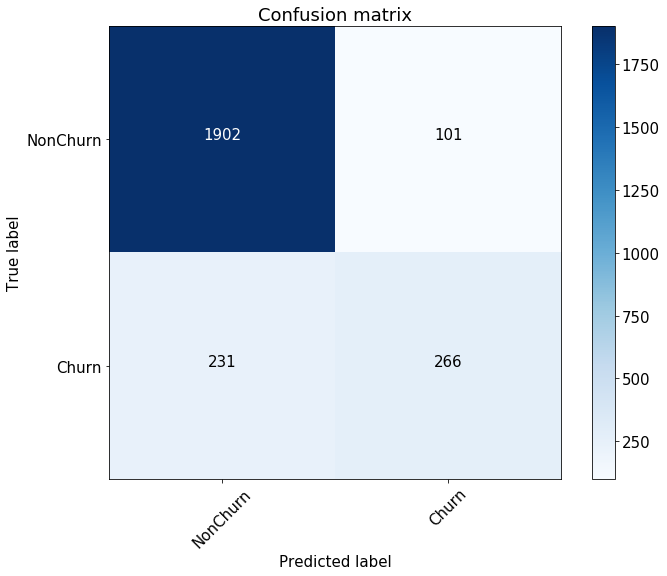

In [17]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
#plt.savefig("conf_matrix.png")
plt.show()

Можно заметить, что мы очень сильно ошибаемся в сторону False Negatives, т.е у нас много тех, кто ушел в отток на самом деле, но при выбранном нами пороге в 0.38 мы не считаем их таковыми. 

### Пример с перебором параметров с помощью GridSearch

Сетка с параметрами

In [18]:
params={'classifier__max_features':[0.3, 0.5, 0.7],
        'classifier__min_samples_leaf':[1, 2, 3],
        'classifier__max_depth':[None]
        }

Запускаем перебор

In [19]:
grid = GridSearchCV(pipeline,
                    param_grid=params,
                    cv=6,
                    refit=False)

search = grid.fit(X_train, y_train)
search.best_params_

{'classifier__max_depth': None,
 'classifier__max_features': 0.3,
 'classifier__min_samples_leaf': 1}

Обучаем модель уже сновыми параметрами

In [20]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(max_depth=None, max_features=0.3, 
                                          min_samples_leaf=1, random_state=42, class_weight="balanced_subsample")),
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

Best Threshold=0.390000, F-Score=0.620, Precision=0.678, Recall=0.571
Confusion matrix, without normalization
[[1876  127]
 [ 219  278]]


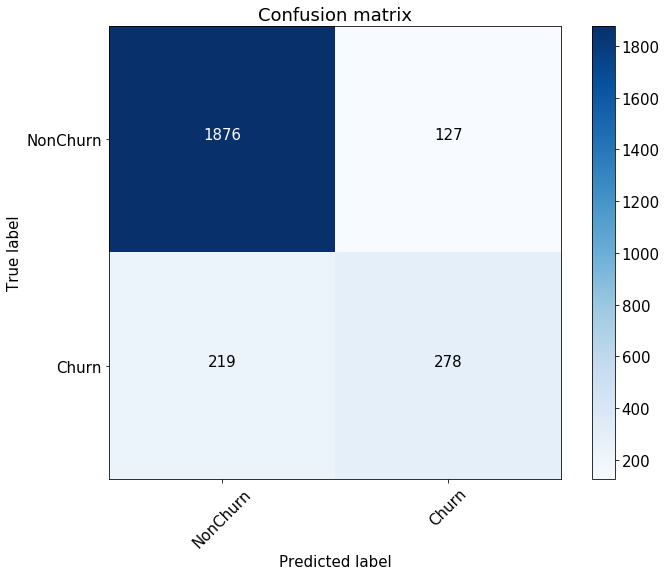

In [21]:
preds = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
#plt.savefig("conf_matrix.png")
plt.show()

Метрики немного стали выше

## Задание:
- Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
- Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
- Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.

In [22]:
def get_scores(y_true, 
               y_predicted, 
               title='Confusion matrix', 
               classes=['Non_churn', 'Churn'], 
               normalize=False):
    """
    calculate:
    - precision
    - recall
    - fscore
    - roc-auc
    - confusion matrix
    """
    precision, recall, thresholds = precision_recall_curve(y_true, y_predicted)
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    roc_auc = roc_auc_score(y_true, y_predicted)
    log_loss_score = log_loss(y_true, y_predicted)
    
    cm = confusion_matrix(y_true, y_predicted>thresholds[ix])
    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]
    TPR = TP/(TP+FN)
    FPR = FP/(FP+TN)
    TNR = TN/(FP+TN)
    
    print(f'\
Threshhold = {thresholds[ix]:.3f}\n\
Precision  = {precision[ix]:.3f}\n\
Recall     = {recall[ix]:.3f}\n\
F-score    = {fscore[ix]:.3f}\n\
ROC_AUC    = {roc_auc:.3f}\n\
Log_loss   = {log_loss_score:.3f}')

    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds_ = roc_curve(y_true, y_predicted, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.show()
    
    font = {'size' : 15}
    plt.rc('font', **font)
    plt.figure(figsize=(10, 8))
    cmap = plt.cm.Blues
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return {
            'Threshold': thresholds[ix],
            'Precision': precision[ix],
            'Recall': recall[ix],
            'F-score': fscore[ix],
            'ROC_AUC': roc_auc,
            'Log_loss': log_loss_score,
            'True_pos': TPR,
            'False_pos': FPR,
            'True_neg': TNR,
            'TN'      : TN,
            'FN'      : FN,
            'TP'      : TP,
            'FP'      : FP
            }

----------------------------------------------------------------------------
LogisticRegression
Наилучшие параметры {'classifier__C': 0.1, 'classifier__class_weight': 'none'}
mean y_score is  0.207
Threshhold = 0.913
Precision  = 0.000
Recall     = 0.000
F-score    = nan
ROC_AUC    = 0.774
Log_loss   = 0.420


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


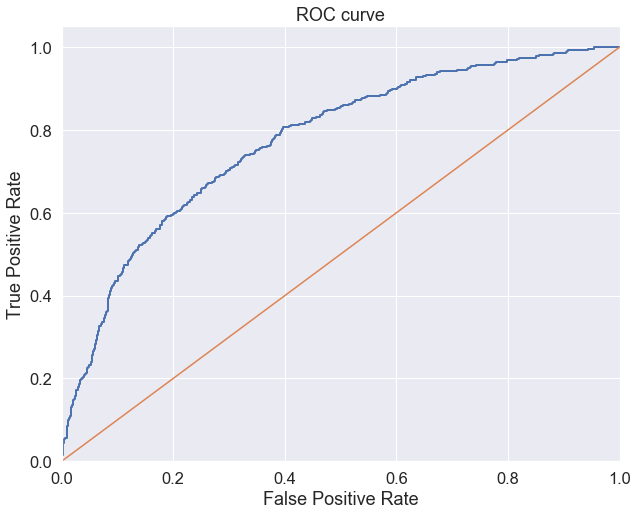

Confusion matrix, without normalization
[[2003    0]
 [ 497    0]]


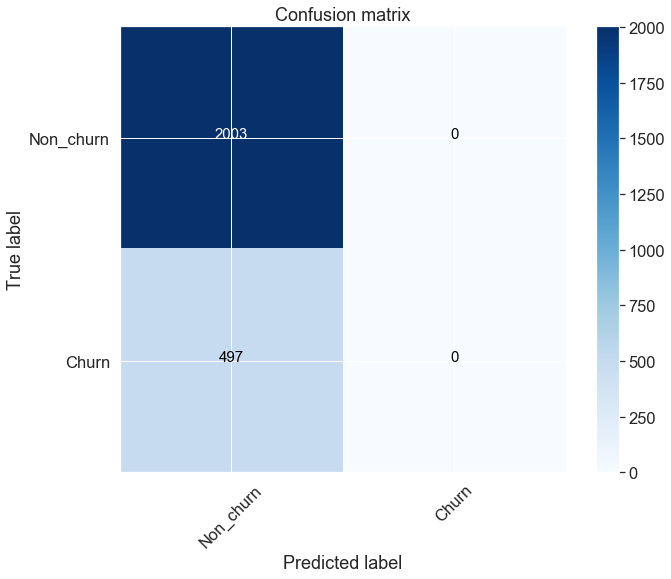

----------------------------------------------------------------------------

GradientBoostingClassifier
Наилучшие параметры {'classifier__max_depth': 5, 'classifier__n_estimators': 50}
mean y_score is  0.203
Threshhold = 0.278
Precision  = 0.608
Recall     = 0.690
F-score    = 0.647
ROC_AUC    = 0.866
Log_loss   = 0.328


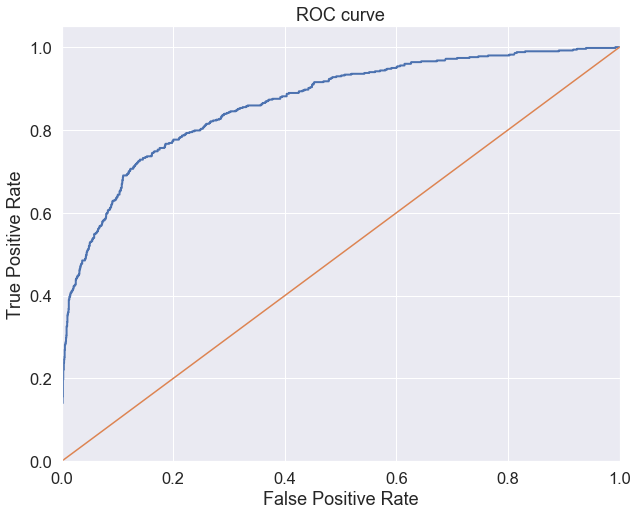

Confusion matrix, without normalization
[[1782  221]
 [ 155  342]]


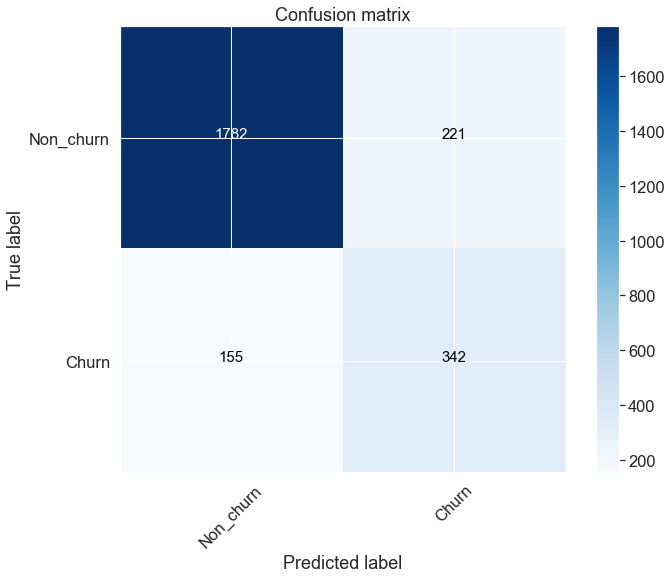

----------------------------------------------------------------------------

Wall time: 1min 10s


In [23]:
%%time
random_state = 42
results = {}
models_names = ['LogisticRegression', 
                'GradientBoostingClassifier']
print('----------------------------------------------------------------------------')
for i, model in enumerate([
                           LogisticRegression(random_state=random_state),
                           GradientBoostingClassifier(random_state=random_state)
                           ]):
    print(models_names[i])
    pipeline = Pipeline([
                        ('features',   feats),
                        ('classifier', model),
                        ])
    if i == 0:
        params = {'classifier__C': [0.001, 0.01, 0.1, 1, 10], 
                  'classifier__class_weight': ['none', 'balanced']}
    else:
        params = {'classifier__n_estimators': [10, 50, 100, 200], 
                  'classifier__max_depth'   : [2, 5, 7, 10]}
    
    gs = GridSearchCV(pipeline, 
                      params, 
                      cv=6, 
                      n_jobs=-1)
    gs.fit(X_train, y_train)
    # наилучшие параметры:
    print('Наилучшие параметры', gs.best_params_)
    y_score = gs.predict_proba(X_test)[:, 1]
    print(f'mean y_score is  {round(np.mean(y_score), 3)}')
    metrics = get_scores(y_test, y_score)
    # отсекаем по лучшим threshold
    threshold = metrics['Threshold']
    y_score = y_score > threshold
    results[models_names[i]] = [y_score, metrics]
    print(f'----------------------------------------------------------------------------\n')

In [24]:
# Сравниваем результаты
def df_highlight_max(s):
    '''
    highlight the maximum
    '''
    is_max = s == s.max()
    return ['color: blue' if v else '' for v in is_max]

def df_bold_max(s):
    '''
    bold the maximum
    '''
    is_max = s == s.max()
    return ['font-weight: bold' if v else '' for v in is_max]

models_acccuracy = pd.DataFrame(columns=models_names)

In [25]:
for i, col in enumerate(models_names):
    if i == 0:
        models_acccuracy = pd.DataFrame.from_dict(results[col][1], orient='index')
    else:
        models_acccuracy = pd.concat([models_acccuracy, 
                                       pd.DataFrame.from_dict(results[col][1], orient='index')],
                                    axis=1)
models_acccuracy.columns = models_names
print('Сравнение качества получившихся данных\nпо столбцам -- модель,\nпо строкам -- метрика,\n\
цветом -- наилучшее значение\n')
models_acccuracy.style.apply(df_highlight_max, axis=1).apply(df_bold_max, axis=1)

Сравнение качества получившихся данных
по столбцам -- модель,
по строкам -- метрика,
цветом -- наилучшее значение



,LogisticRegression,GradientBoostingClassifier
Threshold,0.912633,0.278338
Precision,0.000000,0.608156
Recall,0.000000,0.690141
F-score,nan,0.646560
ROC_AUC,0.773614,0.866122
Log_loss,0.420185,0.328130
True_pos,0.000000,0.688129
False_pos,0.000000,0.110334
True_neg,1.000000,0.889666
TN,2003.000000,1782.000000


По совокупности результатов метрик наиболее качественная модель из рассматриваемых двух - градиентный бустинг.  
В данном случае, f-score позволяет делать более правильную оценку, отражая баланс precision и recall (наша бизнес-цель - верно определить кто уйдет и кто останется).

In [26]:
# Расчет эффективности затрат на привлечение
cost = 1
revenue = 2
TN = results['GradientBoostingClassifier'][1]['TN']  # Правильно определенное удержание
FN = results['GradientBoostingClassifier'][1]['FN']  # НЕправильно определенное удержание
TP = results['GradientBoostingClassifier'][1]['TP']  # Правильно определенный отток
FP = results['GradientBoostingClassifier'][1]['FP']  # НЕправильно определенный отток

In [27]:
efficency = revenue*TP - cost*(TP + FP)
print(f'{"Прибыль" if efficency>=0 else "Убыток"} от удержания = {efficency}$')

Прибыль от удержания = 121$
